In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121
from transformers import TFViTModel

import tensorflow_hub as hub
import tensorflow as tf
import sklearn

In [2]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

In [3]:
def create_resnet_model(image_size):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [4]:
def create_densenet_model(image_size):
    base_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [5]:
def create_mobilenetv2_model(image_size):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [6]:
def create_efficientnetv2_model(image_size):
    base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [7]:
def create_efficientnetv3l_model(image_size):
    base_model = tf.keras.applications.MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [8]:
def create_vgg16_model(image_size):
    base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [9]:
def normalize_image(img, label):
    img = tf.cast(img, np.float32) / 255.0
    return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [10]:
def evaluate_model(model, images_test, labels_test, batch_size=16):

    images_test_2 = tf.cast(images_test, np.float32) / 255.0
    predictions = model.predict(images_test_2, batch_size=batch_size)
    
    auc_per_class = []
    
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    return auc_per_class, balanced_accuracy, accuracy

In [11]:
BATCH_SIZE = 16
NUMBER_OF_IMAGES = 20000
IMAGE_SIZE = 224
evaluations={}

for model_idx in range(4, 6):
    
    sub_evals = []
    
    for run in range(5):


        tf.keras.backend.clear_session()
                
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        images, labels = prepare_data(df[:NUMBER_OF_IMAGES], IMAGE_SIZE)
        images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2, stratify=labels)
        images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], IMAGE_SIZE)
        
        train_dataset = create_train_dataset(images_train, labels_train)
        val_dataset = create_val_dataset(images_val, labels_val)
        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        
        model = None
        
        if model_idx == 0:
            model = create_mobilenetv2_model(IMAGE_SIZE)
        elif model_idx == 1:
            model = create_densenet_model(IMAGE_SIZE)
        elif model_idx == 2:
            model = create_resnet_model(IMAGE_SIZE)
        elif model_idx == 3:
            model = create_efficientnetv2_model(IMAGE_SIZE)
        elif model_idx == 4:
            model = create_vgg16_model(IMAGE_SIZE)
        elif model_idx == 5:
            model = create_efficientnetv3l_model(IMAGE_SIZE)
                    
        model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=50,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=[early_stopping])
        
        print(f'MODEL NUMBER: {model_idx}')
        sub_eval = evaluate_model(model, images_test, labels_test)
        sub_evals.append(sub_eval)
        print(sub_evals)
        
    evaluations[model_idx] = sub_evals
    print(evaluations)

100%|██████████| 4000/4000 [00:58<00:00, 68.47it/s]
2025-03-19 18:26:22.408080: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-19 18:26:22.408769: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-19 18:26:22.409221: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-19 18:26:22.409575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-19 18:26:22.409952: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50


2025-03-19 18:26:38.234578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 156s 152ms/step - auc: 0.5973 - loss: 0.9543 - val_auc: 0.6938 - val_loss: 0.8729
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.6826 - loss: 0.8829 - val_auc: 0.7065 - val_loss: 0.8807
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7053 - loss: 0.8634 - val_auc: 0.7154 - val_loss: 0.8585
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7195 - loss: 0.8516 - val_auc: 0.7224 - val_loss: 0.8550
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7269 - loss: 0.8440 - val_auc: 0.7231 - val_loss: 0.8583
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7331 - loss: 0.8379 - val_auc: 0.7258 - val_loss: 0.8620
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7439 - loss: 0.8293 - val_auc: 0.7300 - val_loss: 0.8470
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7506 - loss: 0.8189 - val_auc: 0.7309 - val_loss: 0.8467
Epoch 9/50
1000/100

100%|██████████| 4000/4000 [00:52<00:00, 75.65it/s]


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 154s 151ms/step - auc: 0.5913 - loss: 0.9364 - val_auc: 0.6937 - val_loss: 0.8702
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 150ms/step - auc: 0.6855 - loss: 0.8670 - val_auc: 0.7061 - val_loss: 0.8586
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 150ms/step - auc: 0.7090 - loss: 0.8502 - val_auc: 0.7086 - val_loss: 0.8660
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 150ms/step - auc: 0.7192 - loss: 0.8399 - val_auc: 0.7133 - val_loss: 0.8494
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 150ms/step - auc: 0.7285 - loss: 0.8336 - val_auc: 0.7150 - val_loss: 0.8549
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 150ms/step - auc: 0.7375 - loss: 0.8217 - val_auc: 0.7145 - val_loss: 0.8743
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 150ms/step - auc: 0.7478 - loss: 0.8135 - val_auc: 0.7168 - val_loss: 0.8584
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 150ms/step - auc: 0.7568 - loss: 0.8034 - val_auc: 0.7172 - val_loss: 0.8475
Epoch 9/

100%|██████████| 4000/4000 [00:56<00:00, 70.37it/s]


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 154s 151ms/step - auc: 0.6186 - loss: 0.9391 - val_auc: 0.7005 - val_loss: 0.8703
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.6929 - loss: 0.8747 - val_auc: 0.7161 - val_loss: 0.8591
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7143 - loss: 0.8562 - val_auc: 0.7223 - val_loss: 0.8671
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7273 - loss: 0.8438 - val_auc: 0.7303 - val_loss: 0.8412
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7366 - loss: 0.8336 - val_auc: 0.7300 - val_loss: 0.8457
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7450 - loss: 0.8272 - val_auc: 0.7256 - val_loss: 0.8523
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7520 - loss: 0.8177 - val_auc: 0.7266 - val_loss: 0.8742
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7596 - loss: 0.8094 - val_auc: 0.7297 - val_loss: 0.8570
Epoch 9/

100%|██████████| 4000/4000 [00:56<00:00, 71.04it/s]


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 154s 151ms/step - auc: 0.5920 - loss: 0.9407 - val_auc: 0.7036 - val_loss: 0.8693
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.6899 - loss: 0.8665 - val_auc: 0.7169 - val_loss: 0.8765
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 150ms/step - auc: 0.7062 - loss: 0.8516 - val_auc: 0.7302 - val_loss: 0.8477
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7175 - loss: 0.8412 - val_auc: 0.7329 - val_loss: 0.8420
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 150ms/step - auc: 0.7285 - loss: 0.8310 - val_auc: 0.7345 - val_loss: 0.8472
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7327 - loss: 0.8272 - val_auc: 0.7351 - val_loss: 0.8440
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 150ms/step - auc: 0.7397 - loss: 0.8182 - val_auc: 0.7355 - val_loss: 0.8372
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 150ms/step - auc: 0.7516 - loss: 0.8072 - val_auc: 0.7347 - val_loss: 0.8363
Epoch 9/

100%|██████████| 4000/4000 [00:51<00:00, 78.35it/s]


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 155s 152ms/step - auc: 0.5945 - loss: 0.9441 - val_auc: 0.7089 - val_loss: 0.8799
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.6851 - loss: 0.8705 - val_auc: 0.7210 - val_loss: 0.8511
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7082 - loss: 0.8506 - val_auc: 0.7261 - val_loss: 0.8518
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7190 - loss: 0.8438 - val_auc: 0.7319 - val_loss: 0.8427
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7267 - loss: 0.8362 - val_auc: 0.7323 - val_loss: 0.8397
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7364 - loss: 0.8273 - val_auc: 0.7333 - val_loss: 0.8403
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7436 - loss: 0.8182 - val_auc: 0.7351 - val_loss: 0.8389
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - auc: 0.7534 - loss: 0.8079 - val_auc: 0.7353 - val_loss: 0.8508
Epoch 9/

100%|██████████| 4000/4000 [00:53<00:00, 74.61it/s]


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 57ms/step - auc: 0.5011 - loss: 0.9803 - val_auc: 0.5766 - val_loss: 0.9318
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - auc: 0.5250 - loss: 0.9365 - val_auc: 0.5919 - val_loss: 0.9352
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - auc: 0.5523 - loss: 0.9297 - val_auc: 0.6047 - val_loss: 0.9238
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - auc: 0.5807 - loss: 0.9224 - val_auc: 0.6135 - val_loss: 0.9203
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - auc: 0.5912 - loss: 0.9181 - val_auc: 0.6197 - val_loss: 0.9166
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - auc: 0.5980 - loss: 0.9156 - val_auc: 0.6245 - val_loss: 0.9137
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - auc: 0.6061 - loss: 0.9129 - val_auc: 0.6247 - val_loss: 0.9532
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - auc: 0.6143 - loss: 0.9106 - val_auc:

100%|██████████| 4000/4000 [00:56<00:00, 71.25it/s]


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 61s 56ms/step - auc: 0.4868 - loss: 0.9947 - val_auc: 0.5771 - val_loss: 0.9462
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - auc: 0.5294 - loss: 0.9503 - val_auc: 0.5932 - val_loss: 0.9322
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5431 - loss: 0.9477 - val_auc: 0.6020 - val_loss: 0.9288
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5652 - loss: 0.9409 - val_auc: 0.6078 - val_loss: 0.9264
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5747 - loss: 0.9382 - val_auc: 0.6128 - val_loss: 0.9242
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5848 - loss: 0.9347 - val_auc: 0.6161 - val_loss: 0.9226
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5895 - loss: 0.9329 - val_auc: 0.6141 - val_loss: 0.9255
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - auc: 0.5984 - loss: 0.9297 - val_auc: 0.6256 - val_loss: 0.9172
Epoch 9/50
1000/1000 ━━━

100%|██████████| 4000/4000 [00:52<00:00, 76.12it/s]


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 56ms/step - auc: 0.4993 - loss: 1.0056 - val_auc: 0.5662 - val_loss: 0.9519
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5395 - loss: 0.9592 - val_auc: 0.5807 - val_loss: 0.9575
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5592 - loss: 0.9534 - val_auc: 0.5929 - val_loss: 0.9431
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5775 - loss: 0.9484 - val_auc: 0.5986 - val_loss: 0.9436
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5923 - loss: 0.9444 - val_auc: 0.6050 - val_loss: 0.9381
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5971 - loss: 0.9417 - val_auc: 0.6088 - val_loss: 0.9358
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.6106 - loss: 0.9370 - val_auc: 0.6107 - val_loss: 0.9346
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.6149 - loss: 0.9335 - val_auc: 0.6129 - val_loss: 0.9345
Epoch 9/50
1000/1000 ━━━

100%|██████████| 4000/4000 [00:52<00:00, 75.84it/s]


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 64s 58ms/step - auc: 0.4975 - loss: 0.9934 - val_auc: 0.5848 - val_loss: 0.9359
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5357 - loss: 0.9387 - val_auc: 0.6001 - val_loss: 0.9376
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5696 - loss: 0.9323 - val_auc: 0.6087 - val_loss: 0.9271
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5848 - loss: 0.9271 - val_auc: 0.6062 - val_loss: 0.9268
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.5957 - loss: 0.9243 - val_auc: 0.6108 - val_loss: 0.9266
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.6087 - loss: 0.9175 - val_auc: 0.6143 - val_loss: 0.9201
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - auc: 0.6131 - loss: 0.9174 - val_auc: 0.6165 - val_loss: 0.9202
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - auc: 0.6156 - loss: 0.9152 - val_auc: 0.6197 - val_loss: 0.9177
Epoch 9/50
1000/1000 ━━━

100%|██████████| 4000/4000 [00:52<00:00, 75.58it/s]


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 66s 59ms/step - auc: 0.5069 - loss: 0.9704 - val_auc: 0.5873 - val_loss: 0.9325
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - auc: 0.5401 - loss: 0.9349 - val_auc: 0.6013 - val_loss: 0.9236
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - auc: 0.5569 - loss: 0.9282 - val_auc: 0.6103 - val_loss: 0.9189
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - auc: 0.5808 - loss: 0.9222 - val_auc: 0.6159 - val_loss: 0.9161
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - auc: 0.5944 - loss: 0.9188 - val_auc: 0.6220 - val_loss: 0.9134
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - auc: 0.6059 - loss: 0.9128 - val_auc: 0.6283 - val_loss: 0.9090
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - auc: 0.6098 - loss: 0.9118 - val_auc: 0.6309 - val_loss: 0.9072
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - auc: 0.6116 - loss: 0.9104 - val_auc: 0.6352 - val_loss: 0.9147
Epoch 9/50
1000/1000 ━━━

In [12]:
# 10,000 samples size224
# mobile and dense net have best val loss after 3 epochs, after that only overfitting


evaluations_mobile = [([0.705199367971001, 0.803903842636237, 0.6460981394492032, 0.7011392571234616], 0.282599714875317, 0.7005),
                      ([0.69857910906298, 0.7825738028322127, 0.686005665937538, 0.718622030585018], 0.27490938833173095, 0.6935),
                      ([0.703420965286759, 0.7771263259402121, 0.6214206039048666, 0.6921624829017055], 0.25222499170745993, 0.6925),
                      ([0.7258387949771093, 0.8135429642694162, 0.6394139616113841, 0.7238595847802269], 0.33982969835560545, 0.6835),
                      ([0.665603367536314, 0.8241186315732858, 0.6309255165638143, 0.714961401958212], 0.2667250064888405, 0.6855)]

evaluations_dense = [([0.7656006003729589, 0.7968915362947189, 0.6445603193731332, 0.734302791443053], 0.2726910672656741, 0.6865),
                     ([0.6881294852036925, 0.8185377809660449, 0.6628734464916098, 0.7216383163168159], 0.2906261544197827, 0.703),
                     ([0.6887140484308069, 0.8160272628698301, 0.6163321029286669, 0.6940791876689312], 0.26448743829481186, 0.674),
                     ([0.7171291196782935, 0.8082851667026081, 0.6470281823152245, 0.7245076918268336], 0.2686624541341933, 0.6835),
                     ([0.7274079761961896, 0.8017894867652542, 0.655972644612711, 0.7097759810004136], 0.2925578221248356, 0.7125)]

evaluations_resnet = [([0.6104132870419503, 0.6840325244930507, 0.5990613088404133, 0.6504207224986226], 0.249909207374812, 0.687),
                      ([0.5720783753185208, 0.6570918918918919, 0.5841528182916409, 0.6229793683938951], 0.2507716049382716, 0.682),
                      ([0.5799318486953476, 0.6543798661645717, 0.6071499222834534, 0.6327051426264024], 0.24981684981684982, 0.682),
                      ([0.599961607423654, 0.7006001776552879, 0.5964987370838117, 0.6351107626644916], 0.2511769286389677, 0.6915),
                      ([0.6405453149001537, 0.6690173906288525, 0.5880346629009731, 0.6407573286531504], 0.2510955806108038, 0.696)]

In [13]:
# 20,000 samples size224 
evaluations_mobile = [([0.704838815597455, 0.8055553700184683, 0.6633923458675319, 0.7225655361828393], 0.33158208642409237, 0.68925), 
                      ([0.68300573083279, 0.7959628880474598, 0.650131888043487, 0.7138845101870103], 0.283828966567713, 0.684),
                      ([0.7182393733064247, 0.7849467540757703, 0.6398127450980393, 0.7039394088398717], 0.25964803219435606, 0.696),
                      ([0.6976476847989594, 0.8176590178675092, 0.6575790844581847, 0.704623688745686], 0.3004115179927809, 0.6925)]

evaluations_dense = [([0.7294378360825581, 0.8240495700218503, 0.6581664146024442, 0.7323697015182481], 0.2833722334573324, 0.6855), 
                     ([0.6986836985153257, 0.8038312278094294, 0.6244299407411453, 0.693680660264377], 0.26462333636233537, 0.6815), 
                     ([0.7054821860960795, 0.8024486406154384, 0.6618956139252634, 0.7126230751999769], 0.2895685709766684, 0.6855), 
                     ([0.7218725389940877, 0.8034263802416195, 0.6596673808508888, 0.7168842937978033], 0.27455063271049823, 0.69875)]

evaluations_vgg16 = [([0.7221943025912425, 0.8067758746177346, 0.6753560445995164, 0.7290617978387248], 0.2860127302842016, 0.68575),
                     ([0.7280236021312261, 0.8140194864173066, 0.6612781414646791, 0.71468822677143], 0.2917244532098595, 0.68525),
                     ([0.7080099491246502, 0.7972112946935921, 0.6622106326446451, 0.70988951593673], 0.3201316927078488, 0.68525),
                     ([0.7325089820593893, 0.8158939100317487, 0.6841038857604381, 0.7265547539433401], 0.30038263070185467, 0.69725),
                     ([0.7449798610705738, 0.8087063808315852, 0.6809395578349792, 0.7336545093273779], 0.30525345793578085, 0.698)]

evaluations_mobilev3 = [([0.6341929138360896, 0.7251110279800101, 0.6184788575757103, 0.6696227399326375], 0.25012460127591707, 0.6835),
                        ([0.6624204579244721, 0.6971046412280189, 0.6148084080931475, 0.665095963356891], 0.25179996672552235, 0.6875),
                        ([0.6530976874019951, 0.7405434471823664, 0.6120371155385992, 0.6690532492039156], 0.25234027064063036, 0.69275),
                        ([0.6352295363668203, 0.7427325392493241, 0.6042538867930158, 0.6798951573361022], 0.2530272888031509, 0.682),
                        ([0.6362670693130356, 0.6845948717948718, 0.6208518998845884, 0.6648166925229552], 0.25022629550917214, 0.6985)]

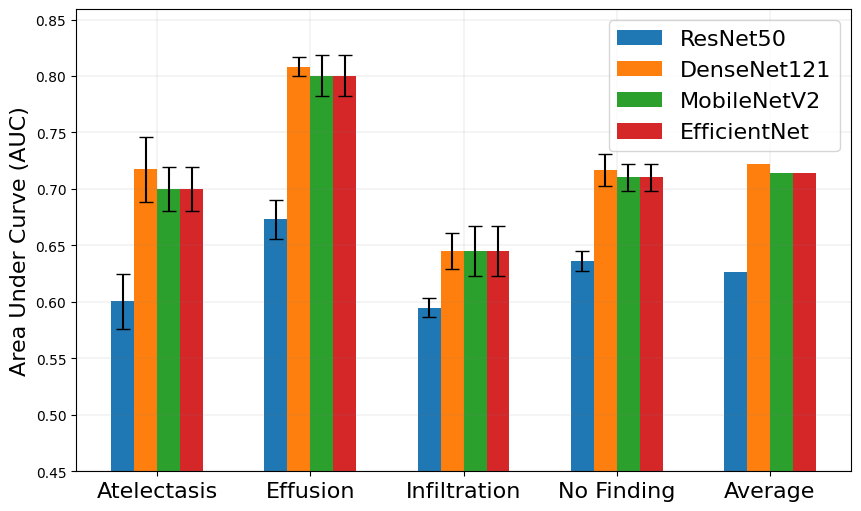

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

resnet50_at, resnet50_ef, resnet50_in, resnet50_nf = [], [], [], []
for eval in evaluations_resnet:
    resnet50_at.append(eval[0][0])
    resnet50_ef.append(eval[0][1])
    resnet50_in.append(eval[0][2])
    resnet50_nf.append(eval[0][3])
resnet50_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [resnet50_at, resnet50_ef, resnet50_in, resnet50_nf])}
resnet50_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [resnet50_at, resnet50_ef, resnet50_in, resnet50_nf])}

dense_at, dense_ef, dense_in, dense_nf = [], [], [], []
for eval in evaluations_dense:
    dense_at.append(eval[0][0])
    dense_ef.append(eval[0][1])
    dense_in.append(eval[0][2])
    dense_nf.append(eval[0][3])
dense_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [dense_at, dense_ef, dense_in, dense_nf])}
dense_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [dense_at, dense_ef, dense_in, dense_nf])}

mobile_at, mobile_ef, mobile_in, mobile_nf = [], [], [], []
for eval in evaluations_mobile:
    mobile_at.append(eval[0][0])
    mobile_ef.append(eval[0][1])
    mobile_in.append(eval[0][2])
    mobile_nf.append(eval[0][3])
mobile_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [mobile_at, mobile_ef, mobile_in, mobile_nf])}
mobile_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [mobile_at, mobile_ef, mobile_in, mobile_nf])}

efficient_at, efficient_ef, efficient_in, efficient_nf = [], [], [], []
for eval in evaluations_mobile:
    efficient_at.append(eval[0][0])
    efficient_ef.append(eval[0][1])
    efficient_in.append(eval[0][2])
    efficient_nf.append(eval[0][3])
efficient_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [efficient_at, efficient_ef, efficient_in, efficient_nf])}
efficient_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [efficient_at, efficient_ef, efficient_in, efficient_nf])}

performance = np.array([[resnet50_means['at'], resnet50_means['ef'], resnet50_means['in'], resnet50_means['nf']],
                        [dense_means['at'], dense_means['ef'], dense_means['in'], dense_means['nf']],
                        [mobile_means['at'], mobile_means['ef'], mobile_means['in'], mobile_means['nf']],
                        [efficient_means['at'], efficient_means['ef'], efficient_means['in'], efficient_means['nf']]])
row_averages = np.mean(performance, axis=1)
performance = np.column_stack((performance, row_averages))

std_dev = np.array([[resnet50_stds['at'], resnet50_stds['ef'], resnet50_stds['in'], resnet50_stds['nf'], np.NaN],
                    [dense_stds['at'], dense_stds['ef'], dense_stds['in'], dense_stds['nf'], np.NaN],
                    [mobile_stds['at'], mobile_stds['ef'], mobile_stds['in'], mobile_stds['nf'], np.NaN],
                    [efficient_stds['at'], efficient_stds['ef'], efficient_stds['in'], efficient_stds['nf'], np.NaN]])


labels = ['Atelectasis', 'Effusion', 'Infiltration', 'No Finding', 'Average']
model_names = ['ResNet50', 'DenseNet121', 'MobileNetV2', 'EfficientNet']
n_models = len(model_names)
n_labels = len(labels)

font_size = 16

x = np.arange(n_labels)  # positions of the labels
width = 0.15  # width of each bar, smaller to fit all models in each label group

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_models):
    ax.bar(x + i * width, performance[i], width, yerr=std_dev[i], label=model_names[i], capsize=5)

ax.set_xticks(x + width * (n_models - 1) / 2)  # Place the x-ticks in the middle of the grouped bars
ax.set_xticklabels(labels, fontsize=font_size)
ax.legend(fontsize=font_size, loc="upper right")
ax.set_ylim(0.45)
ax.set_ylabel("Area Under Curve (AUC)", fontsize=font_size)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# plt.savefig("evals/chestxray8/architecture_10000samples_50epochs_earlystopping.pdf", bbox_inches='tight', pad_inches=0)

plt.show()